# Imports and Data Munging

In [27]:
from __future__ import print_function

import sys
import pyodbc
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math

from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from sklearn.metrics import mean_squared_error
from datetime import datetime

#make the layout full width
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#prefer locally cached copy of SQL Server data
runSql = False

### Load the tip data

In [28]:
tips= pd.read_csv(r'C:\Users\Admin\OneDrive\MyPrograms\NickQuant\Notebooks\JL_UTF8.csv')
tips['DATE'] = pd.to_datetime(tips['DATE'], format="%d/%m/%Y")
tips.head()

,DATE,ANALYST,TIME SENT,EVENT DAY,EVENT START,LOCATION,SPORT,EVENT TYPE,EVENT,RACE,...,GOAT.1,BFSP.1,MID TOTE,HIGHEST FIXED CLOSING PRICE,SB OPENING PRICE,BFSP Converted P&L Less Commission,BFSP Price Less Commission,Fixed,Fixed Converted P&L Less Stake,BOB
0,2017-09-01,John's Analytics,NaN,Fri,1120,New Zealand,Horse Racing,NaN,ASHBURTON,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-09-01,John's Analytics,NaN,Fri,1120,New Zealand,Horse Racing,NaN,ASHBURTON,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-09-01,John's Analytics,NaN,Fri,1520,Australia,Horse Racing,NaN,WYONG,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-09-01,John's Analytics,NaN,Fri,1520,Australia,Horse Racing,NaN,WYONG,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-09-02,John's Analytics,NaN,Sat,1350,New Zealand,Horse Racing,NaN,HASTINGS,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculate tip delta and tip delta rounded

In [29]:
tips['DELTA'] = (tips['BEST FIXED EMAIL SENT'] - tips['BEST FIXED CLOSING']) / tips['BEST FIXED EMAIL SENT']
tips['DELTA ROUNDED'] = tips['DELTA'].apply(lambda x: round(x, 1))
tips.head()

,DATE,ANALYST,TIME SENT,EVENT DAY,EVENT START,LOCATION,SPORT,EVENT TYPE,EVENT,RACE,...,MID TOTE,HIGHEST FIXED CLOSING PRICE,SB OPENING PRICE,BFSP Converted P&L Less Commission,BFSP Price Less Commission,Fixed,Fixed Converted P&L Less Stake,BOB,DELTA,DELTA ROUNDED
0,2017-09-01,John's Analytics,NaN,Fri,1120,New Zealand,Horse Racing,NaN,ASHBURTON,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.566667,0.6
1,2017-09-01,John's Analytics,NaN,Fri,1120,New Zealand,Horse Racing,NaN,ASHBURTON,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.436364,0.4
2,2017-09-01,John's Analytics,NaN,Fri,1520,Australia,Horse Racing,NaN,WYONG,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.062500,-0.1
3,2017-09-01,John's Analytics,NaN,Fri,1520,Australia,Horse Racing,NaN,WYONG,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.029630,0.0
4,2017-09-02,John's Analytics,NaN,Sat,1350,New Zealand,Horse Racing,NaN,HASTINGS,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.571429,0.6


### Grouping and display

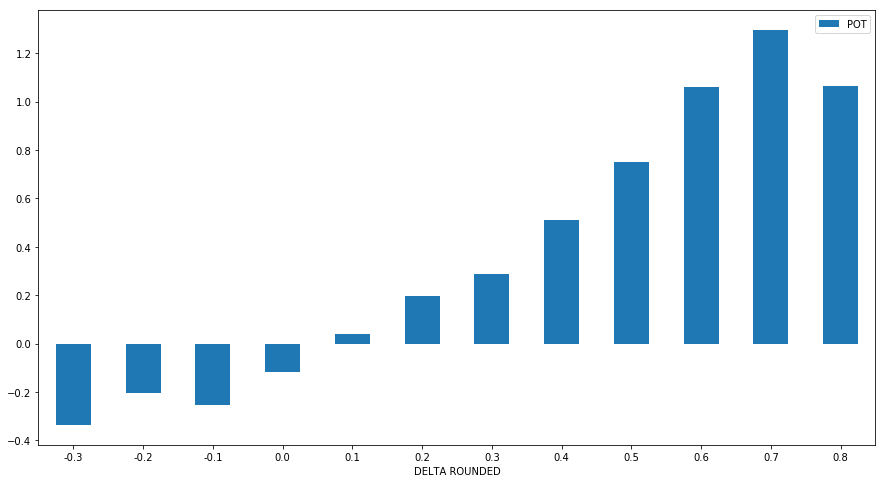

In [30]:
tipsGrouped = tips.groupby(['DELTA ROUNDED']).agg({'P/L':'sum','UNITS INVESTED':'sum' }).reset_index()
tipsGrouped['POT'] = tipsGrouped['P/L'] / tipsGrouped['UNITS INVESTED']

tipsGrouped

tipsGrouped[(tipsGrouped['DELTA ROUNDED'] > -0.4) & (tipsGrouped['DELTA ROUNDED'] < 0.9)].plot.bar(x='DELTA ROUNDED', y='POT', rot=0, figsize=(15,8))

In [31]:
tipsGrouped

,DELTA ROUNDED,P/L,UNITS INVESTED,POT
0,-2.1,-0.30,0.30,-1.000000
1,-1.5,-0.50,0.50,-1.000000
2,-1.4,-1.00,1.00,-1.000000
3,-1.3,-1.30,1.30,-1.000000
4,-1.2,-1.00,1.00,-1.000000
5,-1.1,-0.50,0.50,-1.000000
6,-1.0,8.20,2.00,4.100000
7,-0.9,-1.87,4.55,-0.410989
8,-0.8,-5.10,5.10,-1.000000
9,-0.7,-7.48,9.80,-0.763265


## Analysis of Profitability Usings Closing Prices

PoT for all       bets at closing prices: -0.092708
PoT for all WIN   bets at closing prices: -0.081581
PoT for all PLACE bets at closing prices: -0.100454


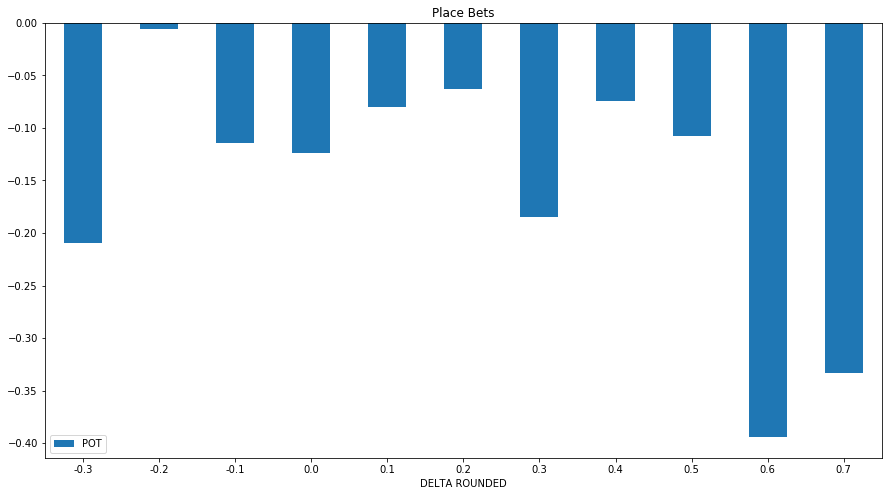

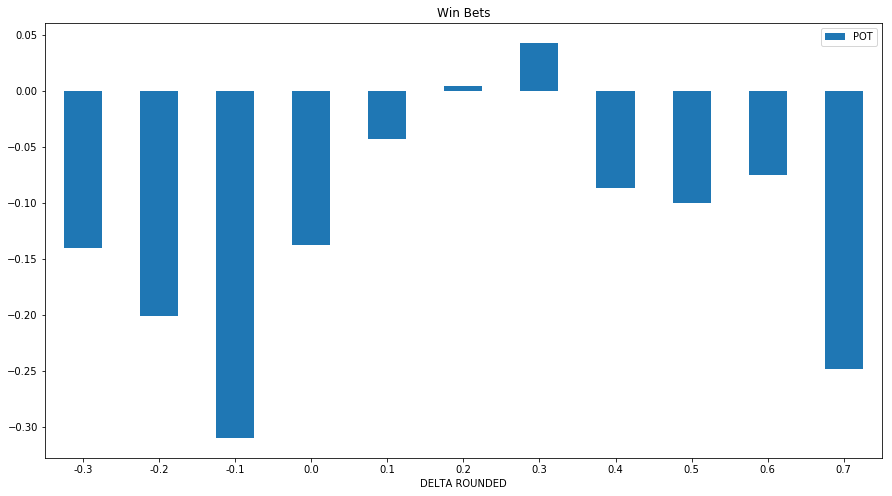

In [33]:
# Change the date period
tipsUsed = tips[tips['DATE']>=datetime.strptime('1-12-2010', '%d-%m-%Y')]

tipsUsed['P/L CLOSING'] = tips['P/L']
tipsUsed.loc[tipsUsed['P/L']>0, 'P/L CLOSING'] = tipsUsed.loc[tipsUsed['P/L']>0, 'BEST FIXED CLOSING'] * tipsUsed.loc[tipsUsed['P/L']>0, 'UNITS INVESTED'] - tipsUsed.loc[tipsUsed['P/L']>0, 'UNITS INVESTED']

tipsGroupedClosing = tipsUsed.groupby(['DELTA ROUNDED','MARKET TYPE']).agg({'P/L CLOSING':'sum','UNITS INVESTED':'sum' }).reset_index()
tipsGroupedClosing['POT'] = tipsGroupedClosing['P/L CLOSING'] / tipsGroupedClosing['UNITS INVESTED']

print('PoT for all       bets at closing prices: ' + '{:4f}'.format(tipsGroupedClosing['P/L CLOSING'].sum() / tipsGroupedClosing['UNITS INVESTED'].sum()))
print('PoT for all WIN   bets at closing prices: ' + '{:4f}'.format(tipsGroupedClosing.loc[tipsGroupedClosing['MARKET TYPE']=='Win', 'P/L CLOSING'].sum() / tipsGroupedClosing.loc[tipsGroupedClosing['MARKET TYPE']=='Win', 'UNITS INVESTED'].sum()))
print('PoT for all PLACE bets at closing prices: ' + '{:4f}'.format(tipsGroupedClosing.loc[tipsGroupedClosing['MARKET TYPE']=='Place', 'P/L CLOSING'].sum() / tipsGroupedClosing.loc[tipsGroupedClosing['MARKET TYPE']=='Place', 'UNITS INVESTED'].sum()))

tipsGroupedClosing[(tipsGroupedClosing['DELTA ROUNDED'] > -0.4) & (tipsGroupedClosing['DELTA ROUNDED'] < 0.8) & (tipsGroupedClosing['MARKET TYPE'] == 'Place')].plot.bar(x='DELTA ROUNDED', y='POT', rot=0, figsize=(15,8), title='Place Bets')
tipsGroupedClosing[(tipsGroupedClosing['DELTA ROUNDED'] > -0.4) & (tipsGroupedClosing['DELTA ROUNDED'] < 0.8) & (tipsGroupedClosing['MARKET TYPE'] == 'Win')].plot.bar(x='DELTA ROUNDED', y='POT', rot=0, figsize=(15,8), title='Win Bets')